In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

In [2]:
# Main function you call from the other script
# Note that you have to tell the other notebook that it should use this notebook, something with % blabla AnalyseFootScan.ipynb
# In case you run it with all pictures better comment the plots...
def analyseFootScan(image, do_visualization):

    # convert to RGB 
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Note: By default OpenCV used BGR

    
    # grab the image dimensions
    h = img_rgb.shape[0]
    #print ("h" + str(h))
    w = img_rgb.shape[1]
    #print ("w" + str(w))
    
    # loop over the image, pixel by pixel
    #for y in range(0, h):
    #    for x in range(0, w):
    #        # threshold the pixel
    #        if img_rgb[y,x,0] <= 20 and img_rgb[y,x,1] >= 20 and img_rgb[y,x,2] >= 230:
    #            print(str(x) + " " + str(y) + " " + str(1))

    #j_heigth = np.size(img_rgb, 0) #heigth
    #print ("heigth" + str(j_heigth))
    #i_width = np.size(img_rgb, 1) #width
    #print ("width" + str(i_width))
    #frameblue = [[0 for y in range(j_heigth+1)]for x in range(i_width+1)] 
    ##frameblue = [[0 for x in range(i_width+1)] for y in range(j_heigth+1)] 
    #for i in range(0, i_width-2): 
    #    for j in range(0,j_heigth-1):       
    #        if img_rgb[j,i,0] <= 20 and img_rgb[j,i,1] >= 20 and img_rgb[j,i,2] >= 230:
     #           print(str(i) + " " + str(j) + " " + str(1))
      #          frameblue[i][j] = 1
       #     else:
        #        #print(str(j) + " " + str(i) + " "+ str(0))
         #       frameblue[i][j] = 0
    ##print(frameblue)
     

    
    # convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #img_gray = img_rgb[:,:,1]

    # visualization of color image and gray-scale
    if do_visualization:
        print('Visualization of foot scan in RGB and grayscale:')
        fig1 = plt.figure(1)
        plt.subplot(121)
        plt.imshow(img_rgb)
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(122)
        plt.imshow(img_gray, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    
    # extract foot region from grayscale image
    # alternatively one could use a separated channel, i.e. red, green or blue
    foot_region = extractFootRegion(img_gray, do_visualization)
    
    # clean grayscale image using extracted foot region
    img_gray_clean = img_gray.copy()
    # get image dimensions
    w = img_gray_clean.shape[1] 
    h = img_gray_clean.shape[0]
    for y in range(0, h): # loop over image
        for x in range(0, w):
            if foot_region[y, x] == 0:
                img_gray_clean[y, x] = 255

    # visualization of clean grayscale image
    if do_visualization:
        print('Visualization of cleaned grayscale:')
        fig2 = plt.figure(2)
        plt.subplot(111)
        plt.imshow(img_gray_clean, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

    # extract foot dimensions
    length_cm, length_dots, width_cm, width_dots = extractFootDimensions(img_gray_clean, do_visualization)
    
    return length_cm, length_dots, width_cm, width_dots

In [3]:
def extractFootRegion(img_gray, do_visualization):
    
    # get binary image via threshold
    ret,img_binary = cv2.threshold(img_gray,245,255,0)
    img_binary = cv2.bitwise_not(img_binary) # to have the foot region white and the background black

    # remove artifacts by opening and closing
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(20,20))
    img_clean = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, element)
    img_clean = cv2.morphologyEx(img_clean, cv2.MORPH_CLOSE, element)
    
    # if multiple objects only keep largest object
    # get contours in binary image
    img_contours = img_clean.copy() # required since contour function modifies image
    some_img, contours, hierarchy = cv2.findContours(img_contours,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_contours,contours,-1,(150,0,0),3) # for visualization
    # check number of objects
    if (len(contours) > 1): 
        print('Warning: There is more than one object in the image!')
        # find index of largest object
        max_idx = 0
        for i in range(1,len(contours)):
            if len(contours[i]) > len(contours[max_idx]):
                max_idx = i
        # delete all objects but the largest one
        for i in range(0,len(contours)):
            if i != max_idx:
                cv2.fillPoly(img_clean, pts =[contours[i]], color=(0,0,0))
    
    # removed artifacts 
    # Note: Just for visualization, opening deletes some pixels and closing adds pixels
    img_artifacts_removed = img_binary - img_clean
    img_artifacts_added = img_clean - img_binary

    if do_visualization:
        print('Visualization of artifact removal and resulting over-approximative foot region:')
        
        fig3 = plt.figure(3)
        plt.subplot(151)
        plt.imshow(img_binary, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(152)
        plt.imshow(img_contours, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(153)
        plt.imshow(img_clean, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(154)
        plt.imshow(img_artifacts_removed, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(155)
        plt.imshow(img_artifacts_added, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

    return img_clean

In [4]:
# Note: By now also toes are considered for width! 
def extractFootDimensions(img_gray_clean, do_visualization):
    
    # get image dimensions
    w = img_gray_clean.shape[1] 
    h = img_gray_clean.shape[0]
    
    ret,img_tresh = cv2.threshold(img_gray_clean,245,255,0)
    img_tresh = cv2.bitwise_not(img_tresh)
    
    # visualization of binary image of foot region based on threshold
    if do_visualization:
        print('Visualization of considered foot region for extraxting dimensions:')
        fig4 = plt.figure(4)
        plt.subplot(111)
        plt.imshow(img_tresh, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    
    row_sum = np.sum(img_tresh, axis=1)
    column_sum = np.sum(img_tresh, axis=0)

    upper_limit = -1
    for y in range(0, h): # loop over image columns
        if row_sum[y] > 0:
            upper_limit = y
            #print(upper_limit)
            break

    lower_limit = -1
    for y in range(h-1,-1,-1):
        if row_sum[y] > 0:
            lower_limit = y
            #print(lower_limit)
            break

    left_limit = -1
    for x in range(0,w):
        if column_sum[x] > 0:
            left_limit = x
            #print(left_limit)
            break

    right_limit = -1
    for x in range(w-1,-1,-1):
        if column_sum[x] > 0:
            right_limit = x
            #print(right_limit)
            break

    foot_length_dots = lower_limit - upper_limit + 1
    foot_length_inch = foot_length_dots/72.0
    foot_length_cm = foot_length_inch * 2.54

    foot_width_dots = right_limit - left_limit + 1
    foot_width_inch = foot_width_dots/72.0
    foot_width_cm = foot_width_inch * 2.54

    print("Foot length is " + str(round(foot_length_cm,2)) + " cm.")
    print("Foot width is " + str(round(foot_width_cm,2)) + " cm.")
    
    # Todo: move this function somewhere else but not important for now. Was just easier like that since I neede all the values...
    # extract toes line
    polyline = extractToesLine(img_gray_clean, lower_limit, upper_limit, left_limit, right_limit, do_visualization)
    
    return round(foot_length_cm,2),round(foot_length_dots,2), round(foot_width_cm,2), round(foot_width_dots,2)

In [5]:
# 1. Do edge detection on whole image. The output is binary. We assume that the toes line is detected as an edge.
# 2. Look at each image column separately and compute peak position based on edge detection and grayscale value.

def extractToesLine(img_gray_clean, lower_limit, upper_limit, left_limit, right_limit, do_visualization):
    
    # use gaussian filter as pre-processing step (otherwise edge detection does not work well)
    img_filtered = cv2.GaussianBlur(img_gray_clean,(3,3),0)

    # do edge detection on grayscale image
    # in this step parameter tuning might improve results a lot, i.e. lower and upper threshold value for canny edge detector
    img_edges = cv2.Canny(img_filtered,40,60)/255.0
    
    # visualization
    if do_visualization:
        fig5 = plt.figure(5)
        plt.subplot(131)
        plt.imshow(img_gray_clean, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(132)
        plt.imshow(img_filtered, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(133)
        plt.imshow(img_edges, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    
    # Now we look at each image column separately and compute one peak value which we wish to be the toes line
    # Therefore we extract a 1D signal and do peak detection.
    peaks = []
    
    # start position of  1D signal in y direction i.e. portion of image column we consider
    # Note: start position is fixed for all columns right now and choosen to be a little bit 
    y_start = int(0.3*(upper_limit+lower_limit))+1  
    
    for x in range(left_limit,right_limit+1): # for each column in foot region 
        
        # end position of signal in y direction
        for y in range(upper_limit,lower_limit):
            if img_gray_clean[y,x] < 255:
                y_end = y + 30
                break
                
        #print(y_start)
        #print(y_end)
        
        # extract edge signal
        edge_signal = img_edges[y_end:y_start,x]
        edge_signal = np.flip(edge_signal,0) # read from heel to toes
        
        # extract grayscale valuesof signal 
        signal = img_gray_clean[y_end:y_start,x] 
        signal = 1 - np.flip(signal/255.0,0) # invert that dark pixels are maxima and read from heel to toes
        
        # ignore this for now, this might be an improvement to just using the grayscale value
        #mask_first = [-3, -2, -1, 1, 2, 3]
        #mask_sec = [9, 12, 10, -2, -18, -28, -18, -2, 10, 12, 9]
        #mask_gauss = [0.25, 0.5, 0.25]
        #signal_conv =  np.convolve(signal, mask_sec, 'same')
        #signal_conv =  np.convolve(signal_conv, mask_gauss, 'same')
        
        # ignore this as well
        #signal_mean = np.mean(signal)*np.ones(len(signal))
        
        # uncommented since these are a lot of plots
        #if do_visualization:
            #img_gray_clean_copy = img_gray_clean.copy()
            #img_gray_clean_copy[y_end:y_start,x-1:x+1] = 0
            
            #img_edges_copy = img_edges.copy()
            #img_edges_copy[y_end:y_start,x-1:x+1] = 1
            
            #fig6 = plt.figure(6)
            #plt.subplot(121)
            #plt.imshow(img_gray_clean_copy, cmap = 'gray')
            #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            #plt.subplot(122)
            #plt.imshow(img_edges_copy, cmap = 'gray')
            #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            #plt.show()
            
            #fig7 = plt.figure(7)
            #plt.plot(signal, 'b')
            #plt.plot(edge_signal, 'r')
            #plt.show()
        
        # detect peak in column considering edge pixels and maximum gray value
        peak_value = 0
        peak_position = 0
        for i in range(0, len(signal)):
            if (edge_signal[i] == 1) and (signal[i] > peak_value):
                peak_position = i
                peak_value = signal[i]
                
        # find lowest background pixel of image column and adjust peak position if higher than lowest background pixel
        for i in range(0, len(signal)):
            if (signal[i] == 0) and (i < peak_position):
                peak_position = i
                
        peak_position = y_start - peak_position;
        
        # store extracted peak position for polyfit
        peaks.append(peak_position)
    
    # visualization of detected peaks
    if do_visualization:
        img_gray_clean_copy2 = img_gray_clean.copy()
        counter = 0
        for x in range(left_limit,right_limit+1): # for each fow in foot region
            y_peak = peaks[counter]
            img_gray_clean_copy2[y_peak,x] = 1
            counter = counter + 1
            
        fig8 = plt.figure(8)
        plt.subplot(111)
        plt.imshow(img_gray_clean_copy2, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    
    # fit polynom to peak positions
    # Todo
    
    return peaks # and here the polynom should be returned
    

h769
w321
Visualization of foot scan in RGB and grayscale:


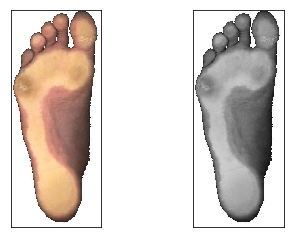

Visualization of artifact removal and resulting over-approximative foot region:


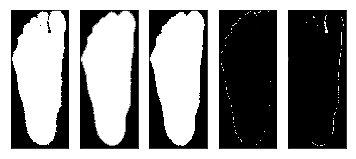

Visualization of cleaned grayscale:


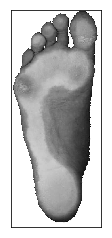

Visualization of considered foot region for extraxting dimensions:


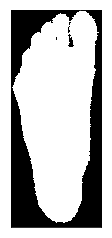

Foot length is 26.63 cm.
Foot width is 10.87 cm.


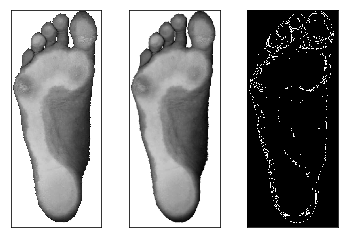

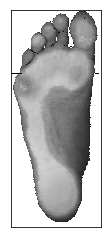

In [6]:
# This is the call that is added in the other notebook:
#image = cv2.imread("4_1.jpg") # load image
#length_cm, length_dots, width_cm, width_dots = analyseFootScan(image, True)

In [7]:
# Ignore this, was just some other stuff I tried...

#img_laplacian = cv2.Laplacian(img_filtered,cv2.CV_8U)
#ret,img_laplacian_binary = cv2.threshold(img_laplacian,240,255,0)
#img_edges = cv2.Sobel(img_filtered,cv2.CV_8U,0,1,ksize=5)

In [ ]:
#import cv2
#import numpy as np
#from matplotlib import pyplot as plt
#image = cv2.imread("00test.png") # load image

In [ ]:
def readBluePointsOfFootScan(image, do_visualization):
   
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #not necessary anymore, because of matplotlib imread
    if do_visualization:
        plt.subplot(131)
        plt.imshow(image)
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

    # list to store points
    points_x= []
    points_y = []
    # temporary list to store points prior to sorting them from 1 to 10
    points_x_temp = []
    points_y_temp = []
    # image dimensions
    w = image.shape[1]
    h = image.shape[0]

    # scan one image row after each other and store points
    for y in range(0, h):
        for x in range(0, w):
            if image[y,x,0] == 0 and image[y,x,1] == 0 and image[y,x,2] == 1: # condition
                points_x_temp.append(x)
                points_y_temp.append(y)
    # check wether 10 points detected
    if len(points_x_temp) != 10:
        print('Attention: wrong number of points detected!    ' + str(len(points_x_temp))+ 'points')
    else:
        print(str(len(points_x_temp))+ 'points are detected')
        # convert temporary list to numpy array
        points_x_temp_np = np.asarray(points_x_temp)
        points_y_temp_np = np.asarray(points_y_temp)
        # sort points from 1 to 10 (start with most left point and go to the right)
        for i in range(0, 7): # points 1-7
            idx = np.argmin(points_x_temp_np[0:7-i])
            points_x.append(points_x_temp_np[idx])
            points_y.append(points_y_temp_np[idx])
            points_x_temp_np = np.delete(points_x_temp_np, idx)
            points_y_temp_np = np.delete(points_y_temp_np, idx)
        for i in range(0, 3): # points 8-10 (again start with most left point and go to the right)
            idx = np.argmin(points_x_temp_np[0:3-i])
            points_x.append(points_x_temp_np[idx])
            points_y.append(points_y_temp_np[idx])
            points_x_temp_np = np.delete(points_x_temp_np, idx)
            points_y_temp_np = np.delete(points_y_temp_np, idx)

    print (points_x)
    print (points_y)
    factor_cm = 2.54/72
    #calculation of coordinates and lengths:
    Fersenbreite_dots = points_x[9] - points_x[7] #P3x - P2x  (9-7)
    Fersenbreite_cm = round(Fersenbreite_dots*factor_cm,2)
    Ballenbreite_dots = points_x[6] - points_x[0] #P10x - P4x (6-0)
    Ballenbreite_cm = round(Ballenbreite_dots*factor_cm, 2)
    D5_x_cm = round((points_x[1] - points_x[8])*factor_cm, 2) #P5x-P1x (1x-8x)
    D4_x_cm = round((points_x[2] - points_x[8])*factor_cm, 2) #P6x-P1x (2x-8x)
    D3_x_cm = round((points_x[3] - points_x[8])*factor_cm, 2) #P7x-P1x (3x-8x)
    D2_x_cm = round((points_x[4] - points_x[8])*factor_cm, 2) #P8x-P1x (4x-8x)
    D1_x_cm = round((points_x[5] - points_x[8])*factor_cm, 2) #P9x-P1x (5x-8x)
    D5_y_cm = round((points_y[1] - points_y[8])*factor_cm, 2) #P5y-P1y (1y-8y)
    D4_y_cm = round((points_y[2] - points_y[8])*factor_cm, 2) #P4y-P1y (2y-8y)
    D3_y_cm = round((points_y[3] - points_y[8])*factor_cm, 2) #P3y-P1y (3y-8y)
    D2_y_cm = round((points_y[4] - points_y[8])*factor_cm, 2)#P2y-P1y (4y-8y)
    D1_y_cm = round((points_y[5] - points_y[8])*factor_cm, 2) #P1y-P1y (5y-8y)
    print('Fersenbreite_dots: ' + str(Fersenbreite_dots))
    print('Fersenbreite_cm: ' + str(Fersenbreite_cm))
    print('D5_x_cm: ' + str(D5_x_cm))
    print('D4_x_cm: ' + str(D4_x_cm))
    print('D3_x_cm: ' + str(D3_x_cm))
    print('D2_x_cm: ' + str(D2_x_cm))
    print('D1_x_cm: ' + str(D1_x_cm))
    print('D5_y_cm: ' + str(D5_y_cm))
    print('D4_y_cm: ' + str(D4_y_cm))
    print('D3_y_cm: ' + str(D3_y_cm))
    print('D2_y_cm: ' + str(D2_y_cm))
    print('D1_y_cm: ' + str(D1_y_cm))


    return Fersenbreite_dots, Fersenbreite_cm, Ballenbreite_dots, Ballenbreite_cm,D5_x_cm, D4_x_cm, D3_x_cm,D2_x_cm,D1_x_cm, D5_y_cm, D4_y_cm, D3_y_cm,D2_y_cm,D1_y_cm


In [ ]:
#to readBluePoints of png
#image = plt.imread('10punkte2.png') # load image
#readBluePointsOfFootScan(image, True)